<a href="https://colab.research.google.com/github/BenjaminMoreau2000/phsx815_week-9-/blob/main/HW11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PHSX 815 Neural Network with Keras tutorial
### How can we predict the quality of wine based on its physical characteristics?
We will download the `wine_quality` dataset from Tensorflow (the Keras backend) to train a neural network to predict wine quality.

In [ ]:
#@title GPU Connector 
#If you run this in Google Colab you can borrow one of their 4000$ GPUs to make it run much faster
!nvidia-smi -L
executeCell = True

GPU 0: Tesla T4 (UUID: GPU-e6221cc2-8d2b-3eea-1133-1b8e2cdaaef7)


In [ ]:
#@title Google Drive Connector

#This is not needed but I included it anyway.
from google.colab import drive
drive.mount('/content/gdrive')
executeCell = True

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow.keras.activations import relu
import tensorflow_datasets as tfds
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#if you want to load the data as tuples, you can use the as_supervised=True argument
data_train = tfds.load('wine_quality',split='train',as_supervised=True)

#looking at just one sample of our data
pt = data_train.take(1)
# type(pt)

#can convert this TakeDataset object to a numpy array (can do this for the whole dataset too)
print("Features and label for first entry")
for features, label in tfds.as_numpy(pt):
    print(features,label)

#we want to load dataset as a a dictionary of tf.Tensors (can't transform tuples to dataframe)
data_train_white = tfds.load('wine_quality/white',split='train')
data_train_red = tfds.load('wine_quality/red',split='train')

#transform dictionary to dataframe - combining red and white wine
df_white = tfds.as_dataframe(data_train_white)
df_red = tfds.as_dataframe(data_train_red)
df = pd.concat([df_white,df_red])

print('number of samples',len(df['quality']))
#what are our output possibilities?
#Response:
#Later on it says that there should be integer values from 5 to 9, but actually this data set includes wines with quality from 3 to 9, so I'm not exactly sure what is being asked.

print('possible wine quality ratings',df['quality'].unique())

Shuffling and writing examples to /root/tensorflow_datasets/wine_quality/white/1.0.0.incompleteRDZQ7B/wine_quality-train.tfrecord


Dataset wine_quality downloaded and prepared to /root/tensorflow_datasets/wine_quality/white/1.0.0. Subsequent calls will reuse this data.
Features and label for first entry
{'alcohol': 9.0, 'chlorides': 0.054, 'citric acid': 0.34, 'density': 1.0008, 'fixed acidity': 7.6, 'free sulfur dioxide': 44.0, 'pH': 3.22, 'residual sugar': 18.35, 'sulphates': 0.550000011920929, 'total sulfur dioxide': 197.0, 'volatile acidity': 0.32} 5


Shuffling and writing examples to /root/tensorflow_datasets/wine_quality/red/1.0.0.incompleteZMOE2I/wine_quality-train.tfrecord


Dataset wine_quality downloaded and prepared to /root/tensorflow_datasets/wine_quality/red/1.0.0. Subsequent calls will reuse this data.
number of samples 6497
possible wine quality ratings [5 6 4 8 7 3 9]


In [ ]:
#do we have any missing data (empty or NaN entries in features or labels)?
#We don't. I look at the output of print(df) just to see if I could spot any as an extra check, but we are indeed all good.
dataNans = df.isnull().values.any()
if not dataNans:
    print("all good!")

all good!


### Preprocessing our labels
Although this may seem like a regression task for a neural network because we are predicting a number (wine quality), the labels are actually *categorical* not *continuous*. If you look at the labels, you see that they are integer values between 5 and 9. Because this is a classification problem, we need to one-hot encode our labels. This means taking our possible outcomes and turning them into arrays of a 1 and 0's. The index of the 1 in the array will tell us which class is which. So, for example, 5 becomes [1,0,0,0,0], 6 becomes [0,1,0,0,0] and so on. We can use a function from sklearn to do this automatically.

this dataset unfortunately only gives us training data - but we can set aside a portion for testing our network on. in practice, you don't want to test your network on data it has already seen (is it really a prediction if you use your model on data it was fitted to?) but, for educational purposes, we can ~randomly sample our data and call it ~iid.
Here, I combine the red and white wine datasets for increased statistics. What happens if you train networks on these datasets separately? Or what happens if you use one dataset to train and one to test?

In [ ]:
#it's helpful to separate our input features from our target features (quality) 
#so we can later only transform our inputs without changing our labels
labels = df['quality']
df = df.drop(labels='quality',axis=1)
labels.unique()

enc = OneHotEncoder(sparse=False)
labels = enc.fit_transform(labels.to_numpy().reshape(-1,1))

#make our test data
df, df_test, labels, df_testLabels = train_test_split(df,labels,test_size=0.1)

#look at the first 5 entries
df.head()

array([5, 6, 4, 8, 7, 3, 9])

,features/alcohol,features/chlorides,features/citric acid,features/density,features/fixed acidity,features/free sulfur dioxide,features/pH,features/residual sugar,features/sulphates,features/total sulfur dioxide,features/volatile acidity
4848,12.5,0.038,0.36,0.99140,7.2,26.0,2.93,5.7,0.59,98.0,0.36
484,9.8,0.041,0.22,0.99570,6.2,26.0,3.44,7.3,0.64,157.0,0.28
1935,11.0,0.015,0.32,0.99278,7.8,47.0,2.99,7.4,0.39,124.0,0.19
444,11.0,0.029,0.18,0.99060,5.7,26.0,3.44,1.4,0.37,104.0,0.32
2554,10.4,0.035,0.28,0.99486,6.2,28.0,3.40,8.5,0.42,108.0,0.25


### some questions to consider:
- how was this data obtained? what goes into engineering the features? what does "quality" mean?
- This was part of the tensorflow prepared datasets that contsists of large amounts of data that we are trying to predict (quality) and large amounts of data that, hopefully, will let us predict that quantity. 
- do you have to normalize your features?
- Yes, the features should normalized around the mean, then you can have a given sample with something like [+.2,-.5,+31] for its normalized result
- are there any correlations among features? is this expected? how can we encode this information to the NN or decouple these features?
- what does the data look like?
- do we have any missing or NaN entries?

let's examine the data to see what kinds of transformations we need to make for preprocessing

In [ ]:
df.describe()

,features/alcohol,features/chlorides,features/citric acid,features/density,features/fixed acidity,features/free sulfur dioxide,features/pH,features/residual sugar,features/sulphates,features/total sulfur dioxide,features/volatile acidity
count,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000
mean,10.498395,0.056051,0.317200,0.994685,7.214418,30.469215,3.219114,5.433111,0.531036,115.558321,0.339820
std,1.196456,0.034763,0.144295,0.003010,1.294181,17.760557,0.160884,4.762535,0.148708,56.495487,0.165221
min,8.000000,0.009000,0.000000,0.987110,3.800000,1.000000,2.720000,0.600000,0.220000,6.000000,0.080000
25%,9.500000,0.038000,0.240000,0.992300,6.400000,17.000000,3.110000,1.800000,0.430000,77.000000,0.230000
50%,10.300000,0.047000,0.310000,0.994880,7.000000,29.000000,3.210000,3.000000,0.510000,118.000000,0.290000
75%,11.300000,0.064500,0.390000,0.996945,7.700000,41.000000,3.320000,8.100000,0.600000,155.000000,0.410000
max,14.900000,0.611000,1.660000,1.038980,15.900000,289.000000,4.010000,65.800003,1.980000,440.000000,1.580000


### Visualizing data
If you want a cool and easy way to visualize not only the features, but also the correlations between features, you can use the following seaborn function, which will display the individual features on the diagonal of the subplots and the correlations between features

`pl = sns.pairplot(df[df.columns], diag_kind='kde')`

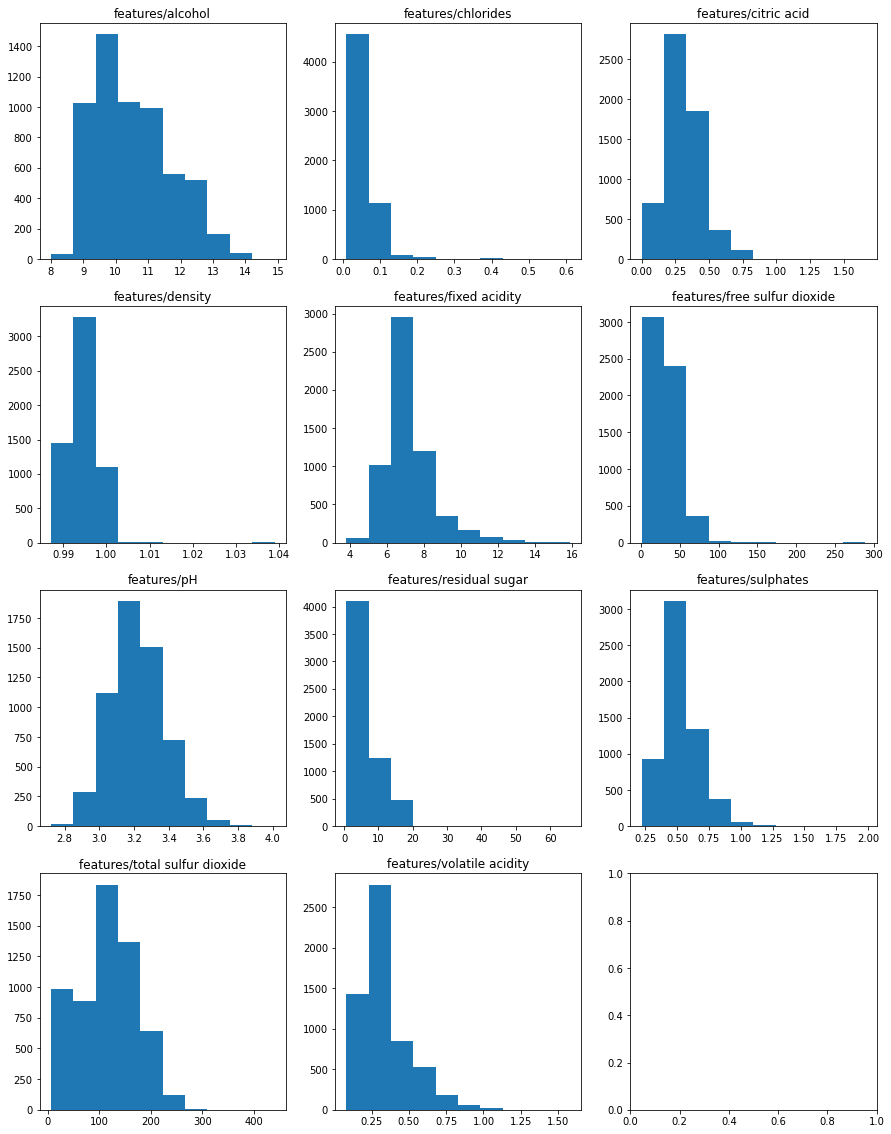

In [ ]:
#visualizing our input features
nFeatures = len(df.columns)
nCols = 3
nRows = int(np.ceil(nFeatures/nCols))
cols = df.columns
fig, axs = plt.subplots(nRows,nCols,figsize=(15,20))
# for i, ax in enumerate(axs)
col = 0
for i in range(nRows):
    for j in range(nCols):
        if col >= nFeatures:
            break
        h = axs[i,j].hist(df[cols[col]])
        h = axs[i,j].set_title(cols[col])
        col += 1

It looks like there are two types of sulfur dioxide features: total sulfur dioxide and free sulfur dioxide. I'm not entirely sure what sulfur dioxide is (I am neither a chemist nor a sommelier) so I'm curious if there is a correlation between these features. 

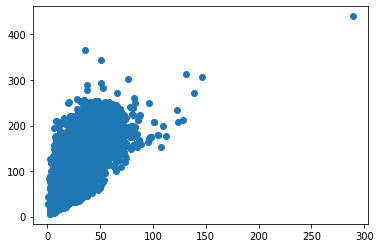

In [ ]:
plt.scatter(df['features/free sulfur dioxide'],df['features/total sulfur dioxide'])

It looks like there is some correlation between these features. If I had to guess, I would say "free sulfur dioxide" is a subset of "total sulfur dioxide" but I'm not sure how or even if either of these features would affect the wine quality. This is where domain specific knowledge would be helpful! Since I have a degree in physics and not wine studies (contrary to what my weekend activities may imply) I am going to see what happens when we include both of these features in our network.

This was just a cursory look at our data. In reality, data scientists will spend most of their time feature engineering, fixing incomplete datasets, cleaning data, etc. Feel free to do more exploratory analysis on the data before you pass it through to a network!

## Let's build our network!
We want to build a simple DNN to essentially perform a categorization. Let's start with something simple: only a couple hidden layers and a handful of neurons. Of course, in accordance with the Universal Approximation Theorem, any function can be approximated arbitrarily well with an arbitrarily large number of layers (Lu et. al. 2017) or arbitrarily large number of neurons (Cybenko 1989). Does the network perform better or worse with an increase in layers or neurons? 
#It depends. Adding more nuerons makes an epoch take longer but generally seems to make the accuracy go up more with each epoch. After trying it many times, quallitatively I'd say its best to have many layers of few neurons with 100 epochs, that seems to be the most effecient


In [ ]:
cols = df.columns
nClasses = len(labels[0])

#using Keras's Sequential model - https://keras.io/api/models/sequential/
model = Sequential()
#add input layer
model.add(Input(shape=(len(cols),))) #the input layer shape should match the number of features we have
#add first layer of fully connected neurons
#model.add(Dense(64,activation='relu'))

#add second layer (first hidden layer)
model.add(Dense(30,activation='relu'))
#model.add(Dense(64,activation='relu'))
'''
#and one more because why not
model.add(Dense(64,activation='relu'))

model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
'''
#add some more
'''
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(264,activation='relu'))
model.add(Dense(1000,activation='relu'))
model.add(Dense(2000,activation='relu'))'''
#finally, our output layer should have only one neuron because we are trying to predict only one number
#notice how there is a different activation function in this layer
#this is because we want our outputs for each class to be a probability
model.add(Dense(nClasses,activation='softmax'))

#compile our model - set our loss metric (categorical cross entropy) and optimizer (stochastic gradient descent)
#how does the model performance change with different optimizers (ie AdaGrad, SGD, etc.)?
model.compile(loss='CategoricalCrossentropy',optimizer='Adam',metrics=['accuracy'])

#let's see a summary of our model
model.summary()

"\n#and one more because why not\nmodel.add(Dense(64,activation='relu'))\n\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dense(64,activation='relu'))\n"

"\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dense(264,activation='relu'))\nmodel.add(Dense(1000,activation='relu'))\nmodel.add(Dense(2000,activation='relu'))"

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 217       
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


As shown above, we have a network with four layers, 128 neurons/layer, for a total of ~50k trainable parameters (remember: parameters are the biases and weights that the network learns). Imagine how many parameters a large, complex network at Google has!

### the same model can be built using the generic Model class and slightly different syntax
`
inputs = tf.keras.Input(shape=(len(cols),))
outputs_L1 = Dense(64, activation='relu')(inputs)
outputs_L2 = Dense(64, activation='relu')(outputs_L1)
outputs_L3 = Dense(64, activation='relu')(outputs_L2)
pred = Dense(1)(outputs_L3)
model = Model(inputs=inputs,outputs=pred)
`

### Training our model

Let's give our model all the input features (df), the corresponding labels (labels)

There is a 20% validation split, which means that 80% of our data will be used to train the model parameters
while 20% of it will be saved to "check" our answers. This is data that the model has not seen (been trained on) so the performance on the validation data should give us an idea of if the model is over- or underfitting.

We will train for 100 epochs, which means that the entire dataset will be passed through the whole network 100 times. Our batch size is 20, meaning that 20 samples at a time are passed to the network before the parameters are updated. The `shuffle` argument ensures that our data is shuffled before the beginning of each epoch to reduce spurious learned correlations. What happens if you let the model run for more epochs?

#Allowing it to run for 1000 epochs gave an average accuracy of about 70 percent near the end, capping at 76%, and it only seemed to increase with more epochs. Increasing the validation split and reducing the number of layers gives poor results (~70) even after allowing it to run for 5000 epochs, so I am to believe that more neurons will be more effecient unless you want the program to run for a really long time.



In [ ]:
history = model.fit(
    df, labels,
    validation_split=0.01,
    verbose=1, epochs=100, batch_size=50, shuffle=True)

Epoch 1/100
116/116 [==============================] - 0s 3ms/step - loss: 1.0946 - accuracy: 0.5275 - val_loss: 0.9646 - val_accuracy: 0.5763
Epoch 2/100
116/116 [==============================] - 0s 3ms/step - loss: 1.0856 - accuracy: 0.5299 - val_loss: 0.9591 - val_accuracy: 0.5763
Epoch 3/100
116/116 [==============================] - 0s 2ms/step - loss: 1.0836 - accuracy: 0.5294 - val_loss: 0.9724 - val_accuracy: 0.5932
Epoch 4/100
116/116 [==============================] - 0s 2ms/step - loss: 1.0847 - accuracy: 0.5321 - val_loss: 0.9585 - val_accuracy: 0.5763
Epoch 5/100
116/116 [==============================] - 0s 2ms/step - loss: 1.0847 - accuracy: 0.5311 - val_loss: 0.9537 - val_accuracy: 0.5932
Epoch 6/100
116/116 [==============================] - 0s 2ms/step - loss: 1.0840 - accuracy: 0.5333 - val_loss: 0.9657 - val_accuracy: 0.5763
Epoch 7/100
116/116 [==============================] - 0s 2ms/step - loss: 1.0842 - accuracy: 0.5289 - val_loss: 0.9627 - val_accuracy: 0.6102

Let's define a function to visualize our loss

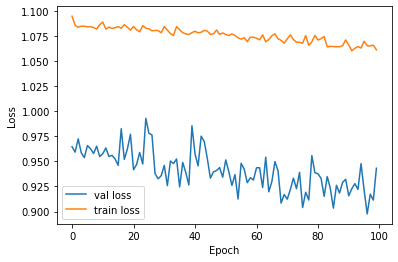

In [ ]:
def show_loss(history):
    plt.figure()
    plt.plot(history.history['val_loss'], label="val loss")
    plt.plot(history.history['loss'],label="train loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
show_loss(history)

It looks like our training loss is more or less monotonically minimized with each epoch (with some fluctuations) while the validation loss seems to be on average higher. The validation loss spikes more severely than the training loss, which is probably due to limited statistics (we only had ~6k samples and took onlt 20% of them for validation - it usually takes LOTS of data to train neural networks well!). The trend discrepancy between training and validation losses could indicate some overfitting in our model. What happens if you increase the percentage of data used for validation? Since it's pretty apparent we're overfitting to our training data, we could introduce some sort of regularization techniques, like L2 regularization (that penalizes large weights) or dropout (that randomly drops neurons in a layer with a set probability). What happens if you introduce some of these methods?

### Remember that test data we set aside at the beginning?
Now it's time to use it to evaluate our model performance!

In [ ]:
_, acc = model.evaluate(df_test, df_testLabels, verbose=1)
print('Accuracy for test data is',acc)

21/21 [==============================] - 0s 2ms/step - loss: 1.0635 - accuracy: 0.5154
Accuracy for test data is 0.5153846144676208


To plot our results, I just chose the highest probability of the classes and assigned the prediction to a class based on that rounding (highest probability gets a 1, every other class gets a 0). Then, I one-hot decoded the rounded array to get a single number for the class. 

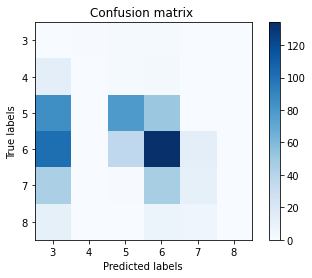

In [ ]:
preds = model.predict(df_test)
preds = [i.round() for i in preds]

preds = enc.inverse_transform(preds)
testLabels = enc.inverse_transform(df_testLabels)
cm = confusion_matrix(testLabels, preds)

_ =plt.imshow(cm, cmap=plt.cm.Blues)
_ = plt.xlabel("Predicted labels")
_ = plt.ylabel("True labels")

_ =plt.xticks(np.arange(0,len(np.unique(testLabels)),1),np.unique(testLabels))
_ =plt.yticks(np.arange(0,len(np.unique(testLabels)),1),np.unique(testLabels))
_ =plt.title('Confusion matrix ')
_ =plt.colorbar()
plt.show()

It looks like our network is only predicting *some* of our classes. Maybe that's because really good wine (rated 8 and 9) is pretty rare? Let's check it out.

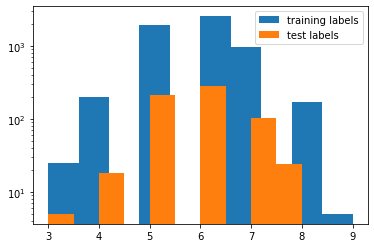

In [ ]:
_=plt.hist(enc.inverse_transform(labels),label='training labels')
_=plt.hist(testLabels,label='test labels')
_=plt.yscale('log')
_=plt.legend()

Yep! Mostly 5s, 6s, and 7s. Only a handful of really good wines (8s and 9s) and really bad wines (3s and 4s). In fact, no scores below a 3! But no perfect 10s either. Overall, I would say that the dataset is imbalanced (mostly ok wines, some bad and some good - a pretty Gaussian distribution) and could benefit from data augmentation techniques like bootstrapping! Maybe you could even generate some more data from randomly sampling a known distribution...But if you train your model on mostly ok wines, then it learns the characteristics of those wines really well. So, when it's faced with a good or bad wine, it's not as sure how to classify it. You can see if this is happening by looking at the network output, which are the probabilities for each class (ie how sure the network is this sample belongs to a certain class).

### Overall, 
our network performs ok with a training, validation, and test accuracy all around 50-60%. What could you change about the network or inputs? How do you think that would affect the model's predictions?

#Need more wines at lower and higher quality values to establish a better correlation. Also, having a much larger data set would likely improve the results because the model has problems with generalization after going into the final step.